## towards_few_shot_learning
Jupyter notebook with some steps towards few shot learning

We run this jupyter notebook within conda and have installed cupy (using conda) and emnist (using pip).

We start defining some functions for later use. They are code folded here to keep the notebook readable.

In [75]:
%%writefile _code_.py


NN2_file_identifier = '_' + str(do_batch_training) + '_' + str(hidden_size) # used for the pickle file to reload pretrained files with different parameters

if use_bias:
    NN2_file_identifier += 'b_'
if do_pm:
    NN2_file_identifier += 'pm'
    
if few_shot_more_at_once != 1:
    print('Special few shot configuration, using additional data in every shot. Not the standard understanding of few shot!!!')
if load_mnist:
    print('labels (last two are used for few_shot)', all_labels)
    
#np.seterr(under='ignore', over='ignore')

def sigmoid(x):
    if do_pm:
        return np.tanh(x)
    xx = scale_sigmoid * (x - shift_sigmoid)
    return 1 / (1 + np.exp(-xx)) #* 2 -1

def sigmoid_derivative(x):
    if do_pm:
        return 1-np.tanh(x)**2
    xx = scale_sigmoid * (x - shift_sigmoid)
    return scale_sigmoid * (np.exp(-xx) / (np.exp(-xx) + 1) ** 2)

def transform_01_mp(x):
    return 2*x - 1

def run_load_mnist(show_msg = True, use_test = False, limit_labels = None, only_load_num = None):
    #global inputs, outputs, bbs
    # simelar to https://www.python-course.eu/neural_network_mnist.php
    #image_size = 28 # width and length
    #no_of_different_labels = 10 #  i.e. 0, 1, 2, 3, ..., 9
    #image_pixels = image_size * image_size
    if not load_mnist:
        print('This should not happen!!')
    data_path = "test_few_shot/data/mnist/" # makes it possible to use kernel from jupyter notebook
    
    # speedup loading
    fac = 0.99 / 255
    if not use_emnist:
        try:
            with open(data_path + "pickled_mnist.pkl", "br") as fh:
                (train_data, test_data) = pickle.load(fh)
        except:
            train_data = np.loadtxt(data_path + "mnist_train.csv", 
                                    delimiter=",")
            test_data = np.loadtxt(data_path + "mnist_test.csv", 
                               delimiter=",") 
            with open(data_path + "pickled_mnist.pkl", "bw") as fh:
                pickle.dump((train_data, test_data), fh)
                
        
        if use_test:
            used_imgs = np_array(test_data[:, 1:]) * fac + 0.01
            dataset_name = 'Test dataset'
            used_labels = np_array(test_data[:, :1])
        else:
            used_imgs = np_array(train_data[:, 1:]) * fac + 0.01
            dataset_name = 'Train dataset'
            used_labels = np_array(train_data[:, :1])
    else:
        if use_test:
            dataset_name = 'Test dataset'
            (used_imgs, used_labels) = extract_test_samples('digits')
        else:
            dataset_name = 'Train dataset'
            (used_imgs, used_labels) = extract_training_samples('digits')
        used_imgs = np_array(used_imgs.reshape(-1, 28*28)) * fac + 0.01
        used_labels = used_labels.reshape(-1,1)
        
    if limit_labels is not None:
        new_imgs = []
        new_labels = []
        for i in range(len(used_labels)):
            if int(used_labels[i][0]) in limit_labels:
                new_imgs.append(used_imgs[i].tolist())
                new_labels.append(used_labels[i].tolist())
                if only_load_num is not None and len(new_labels) >= only_load_num:
                    break
        used_imgs = np_array(new_imgs)
        used_labels = np_array(new_labels)
    
    
    if num_outputs == 1:
        used_labels = np.around(1 - np.sign(np.abs(used_labels - label_to_one)))
    elif num_outputs == 10:
        label_transform = np.zeros((10, 10), int)
        np.fill_diagonal(label_transform, 1)
        label_transform = label_transform.tolist()
        used_labels = [label_transform[int(np.around(x[0]))] for x in used_labels]
        used_labels = np_array(used_labels)
#        raise Exception('not yet implementd')
    else:
        raise Exception('not yet implementd')

    inputs = used_imgs[:first_n_to_use]     
    outputs = used_labels[:first_n_to_use]
    bbs = ''
    for l in np.around(outputs):
        bbs += str(int(l[0]))
    if show_msg:
        if num_outputs == 10:
            if verbose > 0:
                print('loaded mnist', dataset_name,' with 10 labels', limit_labels)
        else:
            print('loaded mnist', dataset_name,' with output labels ',label_to_one,' resulting in learning labels', bbs[:10], '....')
    if len(bbs) > 50:
        bbs = 'to long to plot'
    if do_pm:
        inputs = transform_01_mp(inputs)
        outputs = transform_01_mp(outputs)
    return (inputs, outputs, bbs)


if load_mnist:
    (inputs, outputs, bbs) = run_load_mnist()
else:
    if do_pm: # prepare the fixed inputs, load_mnist does it in the function
        inputs = transform_01_mp(inputs)
        outputs = transform_01_mp(outputs)




vertical_distance_between_layers = 6
horizontal_distance_between_neurons = 2
neuron_radius = 0.5
neuron_scale_line = 2.0
number_of_neurons_in_widest_layer = 4
class Neuron():
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def draw(self, v):
        if v > 0:
            circle = pyplot.Circle((self.x, self.y), radius=neuron_radius, fill=False, color='green', linewidth = 3)
        else:
            circle = pyplot.Circle((self.x, self.y), radius=neuron_radius, fill=False, color='gray', linewidth = 3)
        pyplot.gca().add_patch(circle)

class Layer():
    def __init__(self, network, number_of_neurons, weights, bias, values, slow_learning):
        self.previous_layer = self.__get_previous_layer(network)
        self.y = self.__calculate_layer_y_position()
        self.neurons = self.__intialise_neurons(number_of_neurons)
        self.weights = weights
        if weights is not None:
            self.stability = np.zeros(weights.shape)
        self.drop_weights = None
        self.bias = bias
        self.values = values
        self.slow_learning = slow_learning

    def __intialise_neurons(self, number_of_neurons):
        neurons = []
        x = self.__calculate_left_margin_so_layer_is_centered(number_of_neurons)
        for iteration in range(number_of_neurons):
            neuron = Neuron(x, self.y)
            neurons.append(neuron)
            x += horizontal_distance_between_neurons
        return neurons

    def __calculate_left_margin_so_layer_is_centered(self, number_of_neurons):
        return horizontal_distance_between_neurons * (number_of_neurons_in_widest_layer - number_of_neurons) / 2

    def __calculate_layer_y_position(self):
        if self.previous_layer:
            return self.previous_layer.y + vertical_distance_between_layers
        else:
            return 0

    def __get_previous_layer(self, network):
        if len(network.layers) > 0:
            return network.layers[-1]
        else:
            return None

    def __line_between_two_neurons(self, neuron1, neuron2, linewidth, graylevel = None, usage = None):
        angle = atan((neuron2.x - neuron1.x) / float(neuron2.y - neuron1.y))
        if graylevel is None:
            nr = neuron_radius * neuron_scale_line
        else:
            nr = neuron_radius * 1.4
        x_adjustment = nr * sin(angle)
        y_adjustment = nr * cos(angle)
        line_x_data = (neuron1.x - x_adjustment, neuron2.x + x_adjustment)
        line_y_data = (neuron1.y - y_adjustment, neuron2.y + y_adjustment)
        if linewidth > 0:
            c = 'green'
        else:
            c = 'red'
        
        lw = linewidth * scale_linewidth
        if graylevel is not None:
            #graylevel = (graylevel +1)/2
            if graylevel < 0: graylevel = 0
            if graylevel > 1: graylevel = 1
            c = (0, 0, 1, graylevel)
            lw = linewidth
        if usage is not None:
            #graylevel = (graylevel +1)/2
            if usage < 0: usage = 0
            if usage > 1: usage = 1
            c = (1, 1- usage / 3, 1 - usage)
            lw = linewidth
            
        line = pyplot.Line2D(line_x_data, line_y_data, linewidth=np.abs(lw), color = c)
        pyplot.gca().add_line(line)

    def draw(self, usage):
        for this_layer_neuron_index in range(len(self.neurons)):
            neuron = self.neurons[this_layer_neuron_index]
            neuron.draw(round(self.values[this_layer_neuron_index]))
            if self.previous_layer:
                for previous_layer_neuron_index in range(len(self.previous_layer.neurons)):
                    previous_layer_neuron = self.previous_layer.neurons[previous_layer_neuron_index]
                    weight = self.previous_layer.weights[previous_layer_neuron_index, this_layer_neuron_index]
                    stability = self.previous_layer.stability[previous_layer_neuron_index, this_layer_neuron_index]
                    used = 0
                    if weight > 0:
                        used = self.previous_layer.values[previous_layer_neuron_index] * self.values[this_layer_neuron_index]
                    else:
                        used = self.previous_layer.values[previous_layer_neuron_index] * (1 - self.values[this_layer_neuron_index])
                                                              
                    #print("connection %2d %2d    %6.3f    %6.3f    %6.3f    %6.3f used: %6.3f" % (previous_layer_neuron_index, this_layer_neuron_index, self.previous_layer.values[previous_layer_neuron_index], self.values[this_layer_neuron_index], weight, stability, used))
                    if usage:
                        self.__line_between_two_neurons(neuron, previous_layer_neuron, 4, usage = used)
                    else:
                        if use_stability:
                            self.__line_between_two_neurons(neuron, previous_layer_neuron, 4, stability)
                        else:
                            self.__line_between_two_neurons(neuron, previous_layer_neuron, 4, 0.3)
                    self.__line_between_two_neurons(neuron, previous_layer_neuron, weight)
                    
    def backward(self, post_error):
        
        error_between_sigmoid_and_full = post_error * sigmoid_derivative(self.between_full_sigmoid) # post layer may be wrong!!!!!!!!
        
        pre_error = np.dot(error_between_sigmoid_and_full, self.weights.T) 
        d_weights = np.dot(self.values.T, error_between_sigmoid_and_full) / len(post_error) # scale learning rate per input
        d_bias = np.sum(error_between_sigmoid_and_full, axis = 0) /len(post_error) 
        
        self.change_weights(d_weights, d_bias)
        return pre_error
    
    def forward(self, pre_layer, dostability):
        self.values = pre_layer
        if self.weights is None:
            return pre_layer
        self.between_full_sigmoid = np.dot(pre_layer, self.weights)
        if use_bias:
            self.between_full_sigmoid += self.bias
        post_layer = sigmoid(self.between_full_sigmoid)
        if dostability:
            post_l = np.expand_dims(post_layer,-2)
            pre_l_2d = np.expand_dims(pre_layer, -2)
            
            # this is necessary if 0 1 neurons are used, not if -1 1 ones
            post_l = transform_01_mp(post_l)
            pre_l = transform_01_mp(pre_l_2d)
            
            #print(np.transpose(post_l[2]), pre_l[2])
            stability = (np.tanh(scale_for_neuron_diff * np.matmul(pre_l.swapaxes(-1,-2), post_l)) * np.tanh(self.weights / weight_tanh_scale) + 1) / 2
            stability = pre_l_2d.swapaxes(-1,-2) * stability # only active inputs count for stability
            if len(stability.shape) == 2:
                stability = np.expand_dims(stability, 0) # handle single and multi inputs
            stability = np.sum(stability, axis = 0) / len(stability)
            #print(stability)
            #self.stability = stability_mean * pre_layer.T * stability + (1 - stability_mean * pre_layer.T) * self.stability
            self.stability = stability_mean * stability + (1 - stability_mean) * self.stability
        return post_layer
        
    def change_weights(self, d_weights, d_bias):
        if use_stability:
            direct = 1 - self.stability
        else:
            direct = np_array([1])
        #print('direct', direct)
        self.weights += d_weights * lr * direct * self.slow_learning
        self.bias +=  d_bias *lr * np.sum(direct, axis = 0) * self.slow_learning
        np.clip(self.weights, -clip_weights, clip_weights, self.weights)
        np.clip(self.bias, -clip_bias, clip_bias, self.bias)
        if self.drop_weights is not None:
            self.weights *= self.drop_weights
            
        
class DrawNet():
    def __init__(self):
        self.layers = []
        self.epoch_list = []
        self.error_history = []
        self.error = None

        # batch handling, as cuda might not have enough memory to hold all inputs
        self.all_input = None
        self.all_output = None
        self.batch_pos = None
        self.batch_size = None
        
    def add_layer(self, number_of_neurons, weights, bias, values, slow_learning = 1):
        layer = Layer(self, number_of_neurons, weights, bias, values, slow_learning)
        self.layers.append(layer)
    
    def forward(self, dostability = False):
        outp = self.layers[0].values
        for layer in self.layers:
            outp = layer.forward(outp, dostability)
        #self.layers[-1].values = outp
        self.error = self.y - self.layers[-1].values
        if check_for_nan:
            if np.any(np.isnan(self.error)):
                print('nan')
        return outp
    
    def backward(self):
        #self.error = pre_error = self.y - self.layers[-1].values # forward must be called first anyway
        pre_error = self.error
        for layer in reversed(self.layers[:-1]):
            #print('pre_error', pre_error.flatten())
            pre_error = layer.backward(pre_error)
        return pre_error
    
    def train(self, epochs=1000):
        self.epochs = epochs # just to know how it was trained for output
        self.error_history = []
        self.epoch_list = []
        for epoch in tqdm(range(epochs), mininterval = 10, disable=disable_progressbar):
            # flow forward and produce an output
            self.forward(True)
            # go back though the network to make corrections based on the output
            self.backward()
            self.next_batch()
            # keep track of the error history over each epoch
            self.error_history.append(np.sum(np.square(self.error)))
            self.epoch_list.append(epoch)
        self.forward() # to update the output layer, if one needs to print infos...
    
    def plot_train_history(self):
        pyplot.figure(figsize=(15,5))
        pyplot.plot(self.epoch_list, self.error_history)
        pyplot.xlabel('Epoch')
        pyplot.ylabel('Error')
        pyplot.show()
        pyplot.close()

    def set_input(self, new_input, new_output, batch_size = None):
        self.all_input = new_input
        self.all_output = new_output
        self.batch_size = batch_size
        if batch_size is not None:
            self.layers[0].values = new_input[:batch_size]
            self.y = new_output[:batch_size]
        else:
            self.layers[0].values = new_input
            self.y = new_output
        self.batch_pos = self.batch_size
        
    def next_batch(self):
        if self.batch_size is not None:
            self.layers[0].values = self.all_input[self.batch_pos : self.batch_pos+self.batch_size]
            self.y = self.all_output[self.batch_pos : self.batch_pos+self.batch_size]
            # if len(self.y) == 0:
            #     self.batch_pos = self.batch_size
            #     self.layers[0].values = self.all_input[:self.batch_pos]
            #     self.y = self.all_output[:self.batch_pos]
            if len(self.y) < self.batch_size:
                self.batch_pos = self.batch_size - len(self.y)
                self.layers[0].values = np.concatenate((self.layers[0].values, self.all_input[:self.batch_pos]))
                self.y = np.concatenate((self.y, self.all_output[:self.batch_pos]))
            else:
                self.batch_pos += self.batch_size
            
            
    def draw(self, result = None, usage = False, display_title = None):
        c = 0
        for layer in self.layers:
            c+=1
            #print('layer',c)
            layer.draw(usage)
        if result is not None:
            if result[0] > 0:
                circle = pyplot.Circle((self.layers[-1].neurons[0].x, self.layers[-1].neurons[0].y), radius=neuron_radius+0.3, fill=False, color='green', linewidth = 3)
            else:
                circle = pyplot.Circle((self.layers[-1].neurons[0].x, self.layers[-1].neurons[0].y), radius=neuron_radius+0.3, fill=False, color='gray', linewidth = 3)
            pyplot.gca().add_patch(circle)
        pyplot.axis('scaled')
        if display_title is not None:
            pyplot.title(display_title)
        pyplot.show()
        pyplot.close()
        
    def predict(self, new_input, oo = None, drawit=False, usage = False, display_title = None):
        self.set_input(new_input, oo)
        prediction = self.forward(False)
        if oo is not None:
            self.error = oo - prediction
        if drawit:
            self.draw(oo, usage, display_title)
        return prediction
    
    def count_parameters(self):
        count = 0
        drops = 0
        for l in self.layers:
            if l.weights is not None:
                count += l.weights.size
                if use_bias:
                    count += l.bias.size
                if l.drop_weights is not None:
                    drops += l.drop_weights.size - np.sum(l.drop_weights)
        return count, drops

def setup_net():
    NN2 = DrawNet()
    input_len = len(inputs[0])
    if test_from_random_input:
        input_len = i_bits
    NN2.add_layer(input_len, init_rand_ampl0 * np_array(np.random.rand(input_len, hidden_size) - 0.5), init_rand_ampl0 * np_array(np.random.rand(hidden_size) - 0.5), None, slow_learning = initial_net_first_layer_slow_learning)
    if two_hidden_layers:
        NN2.add_layer(hidden_size, init_rand_ampl * np_array(np.random.rand(hidden_size, hidden_size) - 0.5), init_rand_ampl * np_array(np.random.rand(hidden_size) - 0.5), None)
    NN2.add_layer(hidden_size, init_rand_ampl * np_array(np.random.rand(hidden_size, num_outputs)- 0.5), init_rand_ampl * np_array(np.random.rand(num_outputs) - 0.5), None)
    NN2.add_layer(num_outputs, None, None, None)
    NN2.set_input(inputs, outputs)
    count_drops = 0
    for l in range(len(do_drop_weights)):
        if do_drop_weights[l] > 0:
            NN2.layers[l].drop_weights = np.random.rand(NN2.layers[l].weights.size).reshape(NN2.layers[l].weights.shape) > do_drop_weights[l]
            count_drops += NN2.layers[l].drop_weights.size - np.sum(NN2.layers[l].drop_weights)
    num_params, count_drops = NN2.count_parameters()
    if verbose > 0:
        print('Network parameters: ', num_params, 'dropped', count_drops, 'real parameters', num_params - count_drops, 'drop definition', do_drop_weights)
    
    return NN2


def creat_output_from_int(bb, length=8):
    output = [0]*length
    bbs = ('{0:0'+str(length)+'b}').format(bb)
    for l in range(len(bbs)): 
        if bbs[l] =='1':
            output[l] = [1]
        else:
            output[l] = [0]
    output = np_array(output)
    if do_pm:
        output = transform_01_mp(output)
    return output, bbs

if do_check_all > 0:
    # checks all possible input output combinations to check, if the neural net is capable of learning in
    notok = 0
    sum_error_history = None
    for bb in range(0, check_output_limit):
        # bbs = '{0:08b}'.format(bb)
        # for l in range(len(bbs)): 
        #     if bbs[l] =='1':
        #         outputs[l] = 1
        #     else:
        #         outputs[l] = 0
        (outputs, bbs) = creat_output_from_int(bb)
        NN2 = setup_net()
        NN2.train(do_check_all)
        err = np.sum(NN2.error**2)
        ok = '*'
        if err < 0.2: 
            ok = ' '
        else:
            notok += 1
        if sum_error_history is None:
            sum_error_history = np_array(NN2.error_history)
        else:
            sum_error_history += np_array(NN2.error_history)
        if verbose > 1:
            #print(bbs, '{0:5.3f}'.format(float(err)),ok,notok)
            pyplot.figure(figsize=(15,5))
            pyplot.plot(NN2.epoch_list, NN2.error_history)
            pyplot.xlabel('Epoch')
            pyplot.ylabel('Error')
            pyplot.title(bbs)
            pyplot.show()
            pyplot.close()
        print("Label %8s error %6.3f" % (bbs, err), ok, "total fails yet:", notok)
    pyplot.figure(figsize=(15,5))
    pyplot.plot(NN2.epoch_list, (sum_error_history / check_output_limit).tolist())
    pyplot.xlabel('Epoch')
    pyplot.ylabel('Error')
    pyplot.title('sum error history')
    pyplot.show()
    pyplot.close()


        

# train neural network
#NN2.train()

#testing single inputs for few shot learning
askuser = True
stopit = False
few_shot = (multi_test > 0)


#NN2 = setup_net()
sum_error_history = None
if do_batch_training > 0:
    loaded_pretrained = False
    if try_load_pretrained:
        try:
            with open("pickled_NN2" + NN2_file_identifier + ".pkl", "br") as fh:
                NN2 = pickle.load(fh)
            num_params, count_drops = NN2.count_parameters()
            print('Network parameters: ', num_params, 'dropped', count_drops, 'real parameters', num_params - count_drops, 'drop definition', do_drop_weights)
            loaded_pretrained = True
            print('loaded pretrained net !!!!!!!!!!!!!!!!!!!!!!!!!!!!')
        except Exception as e:
            print('loading pretrained NN2 failed:', e)
            NN2 = setup_net()
    else:
        NN2 = setup_net()    
    if try_mnist_few_shot > 0:
        if loaded_pretrained:
            (inputs, outputs, bbs) = run_load_mnist(limit_labels= all_labels[:-2], only_load_num=few_shot_fast_load_num)
        else:
            (inputs, outputs, bbs) = run_load_mnist(limit_labels= all_labels[:-2])
    NN2.set_input(inputs, outputs, batch_size=1000)
    if not loaded_pretrained:
        try:
            print('start', datetime.now().strftime("%H:%M:%S"))
            NN2.train(do_batch_training)
            print('end', datetime.now().strftime("%H:%M:%S"))
            with open("pickled_NN2" + NN2_file_identifier + ".pkl", "bw") as fh:
                pickle.dump(NN2, fh)
        except KeyboardInterrupt:
            print('Interrupted by keyboard')
    NN2.forward() # most of the time, this should result in an OK net, but not safe, as train could be interrupted at any position
    pyplot.figure(figsize=(15,5))
    pyplot.plot(NN2.epoch_list, (np_array(NN2.error_history) / len(NN2.error)).tolist())
    pyplot.xlabel('Batches')
    pyplot.ylabel('Error')
    pyplot.title('trained with epochs: ' + str(NN2.epochs))
    pyplot.show()
    pyplot.close()
    
    if num_outputs == 1:
        print('train', len(outputs), 'batch_size', NN2.batch_size, '1', int(np.sum(NN2.y > 0.5)), 'wrong', int(np.sum((NN2.y > 0.5) * (NN2.error**2 > 0.25))), 'Ratio', int(np.sum((NN2.y > 0.5) * (NN2.error**2 > 0.25))) / int(np.sum(NN2.y > 0.5)), 'Error', float(np.sum(NN2.error**2) / len(NN2.error)))
    else:
        print('train', len(outputs), 'batch_size', NN2.batch_size, 'correct', float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()), 'of', len(NN2.y), 'Ratio', float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()) / len(NN2.y), 'Error', float(np.sum(NN2.error**2) / len(NN2.error)))
    
    if try_mnist_few_shot > 0:
        (inputs, outputs, bbs) = run_load_mnist(use_test = True,limit_labels=all_labels[:-2], only_load_num=few_shot_fast_load_num)
    else:
        (inputs, outputs, bbs) = run_load_mnist(use_test = True)
        
    NN2.set_input(inputs, outputs, batch_size=1000)
    NN2.forward()
    if num_outputs == 1:
        print('test ', len(outputs), 'batch_size', NN2.batch_size, '1', int(np.sum(NN2.y > 0.5)), 'wrong', int(np.sum((NN2.y > 0.5) * (NN2.error**2 > 0.25))), 'Ratio', int(np.sum((NN2.y > 0.5) * (NN2.error**2 > 0.25))) / int(np.sum(NN2.y > 0.5)), 'Error', float(np.sum(NN2.error**2) / len(NN2.error)))
    else:
        print('test', len(outputs), 'batch_size', NN2.batch_size, 'correct', float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()), 'of', len(NN2.y), 'Ratio', float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()) / len(NN2.y), 'Error', float(np.sum(NN2.error**2) / len(NN2.error)))

    print('Testing if new lables were not learned !!!!!!!!!')
    if try_mnist_few_shot > 0:
        (inputs, outputs, bbs) = run_load_mnist(use_test = True,limit_labels=all_labels[-2:], only_load_num=few_shot_fast_load_num)
    else:
        (inputs, outputs, bbs) = run_load_mnist(use_test = True)
        
    NN2.set_input(inputs, outputs, batch_size=1000)
    NN2.forward()
    if num_outputs == 1:
        print('new  ', len(outputs), 'batch_size', NN2.batch_size, '1', int(np.sum(NN2.y > 0.5)), 'wrong', int(np.sum((NN2.y > 0.5) * (NN2.error**2 > 0.25))), 'Ratio', int(np.sum((NN2.y > 0.5) * (NN2.error**2 > 0.25))) / int(np.sum(NN2.y > 0.5)), 'Error', float(np.sum(NN2.error**2) / len(NN2.error)))
    else:
        print('new  ', len(outputs), 'batch_size', NN2.batch_size, 'correct', float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()), 'of', len(NN2.y), 'Ratio', float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()) / len(NN2.y), 'Error', float(np.sum(NN2.error**2) / len(NN2.error)))

    # now try a few shot learning for some steps
    # load with labels [8,9] and train every to a measure
    #
    # criteria label correct: (NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1))[0] true
    # distance to second largest label
    # biggest_two = np.partition(NN2.layers[-1].values[0], -2)[-2:]
    # ratio = biggest_two[-1] / [-2] > threshold
    
    # max_iter is the maximal number of try's to optimize one data point in few_shot
    pos_1 = 0
    pos_2 = 0
    try:
        print('few shot accuracy results')
        print('shot     try       old labels            new labels  new labels (forced)              over all')
        for i_shot in range(try_mnist_few_shot): # some shots
            if change_first_layers_slow_learning is not None:
                for l in range(len(change_first_layers_slow_learning)):
                    before = NN2.layers[l].slow_learning
                    NN2.layers[l].slow_learning = change_first_layers_slow_learning[l]
                    if verbose > 0:
                        print('slow learning of layer',l,'changed from', before, 'to', NN2.layers[l].slow_learning)
            before = lr
            lr = lr_few_shot
            if verbose > 0:
                print('\n',i_shot + 1,'. shot --- lr changed from',before,'to', lr)
            (inputs, outputs, bbs) = run_load_mnist(use_test = False)
            few1 = all_labels[-2]
            few2 = all_labels[-1]
            while outputs[pos_1].argmax() != few1:
                pos_1 += 1
            while outputs[pos_2].argmax() != few2:
                pos_2 += 1
            inp_1 = inputs[pos_1:pos_1+few_shot_more_at_once]
            outp_1 = outputs[pos_1:pos_1+few_shot_more_at_once]
            inp_2 = inputs[pos_2:pos_2+few_shot_more_at_once]
            outp_2 = outputs[pos_2:pos_2+few_shot_more_at_once]
            pos_1 += few_shot_more_at_once # prepare the next shot
            pos_2 += few_shot_more_at_once
            for m in range(use_every_shot_n_times):
                for (inp,outp) in [(inp_1,outp_1), (inp_2,outp_2)]:
                    if verbose > 0:
                        print('start training', outp)
                    epoch = 0
                    NN2.set_input(inp, outp)
                    while epoch < few_shot_max_try:
                        NN2.forward()
                        NN2.backward()
                        # criterium for stopping is only used for the first element, which is the one few shot is done for. The other elements are not checked, but only used for stabilizing old learned data
                        if (NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1))[0]:
                            biggest_two = np.partition(NN2.layers[-1].values[0], -2)[-2:]
                            if do_pm:
                                ratio = (biggest_two[-1] + 1) / (biggest_two[-2] + 1) / 2 # do_pm means rsults between -1 and 1
                            else:
                                ratio = biggest_two[-1] / biggest_two[-2]
                            if verbose > 0:
                                print(biggest_two, ratio)
                            if ratio > few_shot_threshold_ratio and biggest_two[-1] > few_shot_threshold:
                                break
                if verbose > 0:
                    print('Results after few shot', i_shot + 1, 'used the ', m + 1, '. time')
                    (inputs, outputs, bbs) = run_load_mnist(use_test = False,limit_labels=all_labels[:-2], only_load_num=few_shot_fast_load_num)
                    NN2.set_input(inputs, outputs, batch_size=1000)
                    NN2.forward()
                    print('outputs', len(outputs), 'batch_size', NN2.batch_size, 'few1:', np.sum(NN2.layers[-1].values.argmax(axis = 1) == few1), 'few2:', np.sum(NN2.layers[-1].values.argmax(axis = 1) == few2), 'correct', float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()), 'of', len(NN2.y), 'Ratio', float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()) / len(NN2.y), 'Error', float(np.sum(NN2.error**2) / len(NN2.error)))
                    (inputs, outputs, bbs) = run_load_mnist(use_test = False,limit_labels=all_labels[-2:], only_load_num=few_shot_fast_load_num)
                    NN2.set_input(inputs, outputs, batch_size=1000)
                    NN2.forward()
                    print('outputs', len(outputs), 'batch_size', NN2.batch_size, 'few1:', np.sum(NN2.layers[-1].values.argmax(axis = 1) == few1), 'few2:', np.sum(NN2.layers[-1].values.argmax(axis = 1) == few2), 'correct', float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()), 'of', len(NN2.y), 'Ratio', float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()) / len(NN2.y), 'Error', float(np.sum(NN2.error**2) / len(NN2.error)))
                (inputs, outputs, bbs) = run_load_mnist(use_test = True,limit_labels=all_labels[:-2], only_load_num=few_shot_fast_load_num)
                NN2.set_input(inputs, outputs, batch_size=1000)
                NN2.forward()
                acc_only_old_labels = float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()) / len(NN2.y)
                if verbose > 0:
                    print('outputs', len(outputs), 'batch_size', NN2.batch_size, 'few1:', np.sum(NN2.layers[-1].values.argmax(axis = 1) == few1), 'few2:', np.sum(NN2.layers[-1].values.argmax(axis = 1) == few2), 'correct', float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()), 'of', len(NN2.y), 'Ratio', float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()) / len(NN2.y), 'Error', float(np.sum(NN2.error**2) / len(NN2.error)))
                (inputs, outputs, bbs) = run_load_mnist(use_test = True,limit_labels=all_labels[-2:], only_load_num=few_shot_fast_load_num)
                NN2.set_input(inputs, outputs, batch_size=1000)
                NN2.forward()
                acc_only_new_labels = float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()) / len(NN2.y)
                if verbose > 0:
                    print('outputs', len(outputs), 'batch_size', NN2.batch_size, 'few1:', np.sum(NN2.layers[-1].values.argmax(axis = 1) == few1), 'few2:', np.sum(NN2.layers[-1].values.argmax(axis = 1) == few2), 'correct', float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()), 'of', len(NN2.y), 'Ratio', float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()) / len(NN2.y), 'Error', float(np.sum(NN2.error**2) / len(NN2.error)))
                
                # here only the few_shot trained lables are considdered
                res_values = NN2.layers[-1].values
                mask = [0] * len(all_labels)
                for l in all_labels[-2:]:
                    mask[l] = 1
                mask = np_array([mask])
                res_values = res_values * mask
                # deb = float((res_values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum())
                acc_only_new_labels_forced = float((res_values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()) / len(NN2.y)
                if verbose > 0:
                    print('using only the few shot trained labels for possible output of neural net')
                    print('outputs', len(outputs), 'batch_size', NN2.batch_size, 'few1:', np.sum(res_values.argmax(axis = 1) == few1), 'few2:', np.sum(res_values.argmax(axis = 1) == few2), 'correct', float((res_values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()), 'of', len(NN2.y), 'Ratio', float((res_values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()) / len(NN2.y), 'Error', float(np.sum(NN2.error**2) / len(NN2.error)))
                
                
                
                (inputs, outputs, bbs) = run_load_mnist(use_test = True, only_load_num=few_shot_fast_load_num)
                NN2.set_input(inputs, outputs, batch_size=1000)
                NN2.forward()
                acc_only_overall_labels = float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()) / len(NN2.y)
                if verbose > 0:
                    print('outputs', len(outputs), 'batch_size', NN2.batch_size, 'few1:', np.sum(NN2.layers[-1].values.argmax(axis = 1) == few1), 'few2:', np.sum(NN2.layers[-1].values.argmax(axis = 1) == few2), 'correct', float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()), 'of', len(NN2.y), 'Ratio', float((NN2.layers[-1].values.argmax(axis = 1) == NN2.y.argmax(axis=1)).sum()) / len(NN2.y), 'Error', float(np.sum(NN2.error**2) / len(NN2.error)))
                print("%4d    %3d           %7.3f               %7.3f              %7.3f               %7.3f" % (i_shot + 1, m + 1, acc_only_old_labels, acc_only_new_labels, acc_only_new_labels_forced, acc_only_overall_labels))
    except KeyboardInterrupt:
        print('Interrupted')
else:
    NN2 = setup_net()

multi = 0
while multi <= multi_test:
    # tries to do a few shot learning multiple times and checks, how fast it is learned
    # initializes the last layer weights when the label is changed
    pos_under_few_shot = 0
    if test_from_random_input:
        inp = []
        while len(inp) < 8:
            r = random.randrange(0,2**i_bits-1)
            if r not in inp:
                inp.append(r)
        inputs = []
        for bb in inp:
            v= [0]*i_bits
            bbs = ('{0:0'+str(i_bits)+'b}').format(bb)
            for l in range(len(bbs)): 
                if bbs[l] =='1':
                    v[l] = 1
                else:
                    v[l] = 0
            inputs.append(v)
        inputs = np_array(inputs)
    if not load_mnist:
        (outputs, bbs) = creat_output_from_int(random.randrange(0,check_output_limit - 1)) # first output always 0, as sigmoid network is not capable of outputting 1 here
        disp_label = bbs
    else:
        label_to_one = random.randrange(0, 9) # change the label used
        run_load_mnist(False)
        disp_label = label_to_one
        
    # reset weights in the last layer
    NN2.layers[-2].weights = init_rand_ampl * np_array(np.random.rand(hidden_size, 1)- 0.5)
    NN2.layers[-2].bias = init_rand_ampl * np_array(np.random.rand(1)- 0.5)

    NN2.set_input(inputs, outputs)
    # used to reset whole NN every time
    #NN2 = setup_net()

    error_history = []
    epoch_list = []
    epoch = 0
    while epoch < max_iter:
        for i in range(len(inputs)):
            same = True
            first = True
            fl = 0
            while same:
                if not few_shot:
                    same = False
                if askuser and multi_test == 0:
                    same = True
                    NN2.predict(inputs[i], outputs[i], True, usage = False)
                    # t = '3' 
                    doask = True
                    while doask:
                        doask = False
                        t = input(str(i)+' '+str(NN2.error)+' (1: same, 2:next, 3:stop asking, 4:exit, 5:few_shot, 6: change max epoch num)?')
                        if t.isdigit():
                            t = int(t)
                            if t == 2:
                                same = False
                                break
                            if t == 3:
                                askuser = False
                                same = False
                            if t == 4:
                                stopit = True
                                break
                            if t == 5:
                                few_shot = True
                                askuser = False
                            if t == 6:
                                max_iter = int(input('change max epoch num ' + str(max_iter) + ' '))
                                doask = True
                NN2.set_input(inputs[i:i+1], outputs[i:i+1])
                NN2.forward(dostability = first)
                NN2.backward()
                first = False
                this_error = sum(np.square(NN2.error))
                if this_error[0] > few_shot_end:
                    pos_under_few_shot = epoch + 1
                if len(epoch_list) == 0 or (len(epoch_list) > 0 and epoch_list[-1] != epoch + i / len(inputs)):
                    epoch_list.append(epoch + i / len(inputs))
                    error_history.append(this_error)
                fl += 1
                if fl > few_shot_max_try:
                    break
                if few_shot:
                    if abs(NN2.error[0]) < few_shot_end:
                        break
            if stopit:
                break
        if stopit:
            break
        NN2.set_input(inputs, outputs)
        NN2.forward()
        err = outputs - NN2.layers[-1].values
        NN2.predict(inputs[0], outputs[0], multi_test == 0, display_title = str(epoch)+': '+'{0:6.3f}'.format(float(np.sum(err**2))))
        epoch += 1
    

    if multi_test == 0:
        for i in range(len(inputs)):
            print(NN2.predict(inputs[i], outputs[i], drawit= (multi_test > 0), usage = True), 'correct', outputs[i])
    
    # plot the error over the entire training duration
    if sum_error_history is None:
        sum_error_history = np_array(error_history)
    else:
        sum_error_history += np_array(error_history)
    if verbose > 0:
        pyplot.figure(figsize=(15,5))
        pyplot.plot(epoch_list, error_history)
        pyplot.xlabel('Epoch')
        pyplot.ylabel('Error')
        pyplot.title(str(multi)+ ' ' + bbs)
        pyplot.show()
        pyplot.close()
    
    print("%3d Label %3s Error %6.3f     Ready %3d" % (multi, str(disp_label), np.sum(np_array(error_history[-8:])), pos_under_few_shot))
    multi += 1
if sum_error_history is not None:
        pyplot.figure(figsize=(15,5))
        pyplot.plot(epoch_list, (sum_error_history / multi_test).tolist())
        pyplot.xlabel('Epoch')
        pyplot.ylabel('Error')
        pyplot.title('sum error history')
        pyplot.show()
        pyplot.close()


Overwriting _code_.py


Here a set of constants are defined, which control the configuration of the test network. There are a number of constants, which are not important at the moment, as it the code is a playing tool.

In [93]:
#import cupy as np # helps with the math (Cuda supported: faster for hidden_size > 256 probably and most mnist cases with batch training)
import numpy as np # helps with the math (if no Cuda is availible or size is small for simple tests)
from matplotlib import pyplot
from math import cos, sin, atan
import random
import pickle
from datetime import datetime
from tqdm import tqdm
from emnist import extract_training_samples, extract_test_samples

def np_array(x):
    return np.array(x)# , dtype = np.float32) # float32 is 3 times faster on batch training with GTX1070Ti and 70 times faster than i7-4790K with float64, cpu does not help float32 a lot)
check_for_nan = True

pyplot.rcParams['figure.dpi'] = 150
pyplot.interactive(False) # seems not to fix memory issue

verbose = 0

do_check_all = 0 #1000            # 0 to turn off
check_output_limit = 128        # number of output combinations, as not every neural net is capable of learning input 0 0 0 -> output 1, if 128 the output to the first input is always 0    

multi_test = -1 #1000             # -1 to turn off
max_iter = 30

hidden_size = 8
two_hidden_layers = True
use_bias = False

lr = 2
lr_few_shot = 0.5
use_stability = False
stability_mean = 0.1
clip_weights = 1 # (clipping to 1 was used for most tests)
clip_bias = 1
init_rand_ampl = 0.1
init_rand_ampl0 = 0.1 # for first layer    (2 was used for most tests to make the first layer a mostly random layer)

# drawing parameters
scale_linewidth = 0.1
weight_tanh_scale = 0.1
scale_for_neuron_diff = 1

scale_sigmoid = 3
shift_sigmoid = 1

few_shot_end = 0.7 # for early tests (no mnist)
few_shot_max_try = 100
few_shot_threshold_ratio = 1.5 # for mnist
few_shot_threshold = 0.3

# if 1 it is standard understanding of few shot learning, giving on data point at each shot, otherwize it adds more data points from availible training data to each shot
few_shot_more_at_once = 1


all_labels = [0, 1, 9, 3, 4, 5, 6, 7, 8, 2]
# random.shuffle(all_labels)    # if shuffeld, preloading can not work !!!!!

try_load_pretrained = False
few_shot_fast_load_num = 4000 # should also handle the batch_sizes for displaying batch training results properly

test_from_random_input = False
i_bits = 8

# input data
inputs = np_array([[0, 0, 0],
                   [0, 0, 1],
                   [0, 1, 0],
                   [0, 1, 1],
                   [1, 0, 0],
                   [1, 0, 1],
                   [1, 1, 0],
                   [1, 1, 1]])

# output data
outputs = np_array([[0], [0], [0], [0], [1], [1], [0], [1]])

# swith to tanh and making input and output 1 -1 instead of 1 0
do_pm = False

use_emnist = False
load_mnist = False

do_batch_training = 0
do_drop_weights = [] # [0.9,0.9]
initial_net_first_layer_slow_learning = 0.1 # most tests are done with 0.1 here, just try if it was really necessary

first_n_to_use = 600000
label_to_one = 5

num_outputs = 1 # most early test need this to be 1, later with mnist dataset this can be set to 10 eg.

try_mnist_few_shot = 10
use_every_shot_n_times = 10 # every data is used n times. so one shot means the data from first shot is used n times
change_first_layers_slow_learning = [0.1, 1] # [0, 0.1]

disable_progressbar = True
# End of constant definitions

We define a input output combination, which should be learned

In [94]:
for i in range(len(outputs)):
    print(inputs[i][0], inputs[i][1], inputs[i][2], '-->', outputs[i])

0 0 0 --> [0]
0 0 1 --> [0]
0 1 0 --> [0]
0 1 1 --> [0]
1 0 0 --> [1]
1 0 1 --> [1]
1 1 0 --> [0]
1 1 1 --> [1]


Now let's test training the net and draw the result

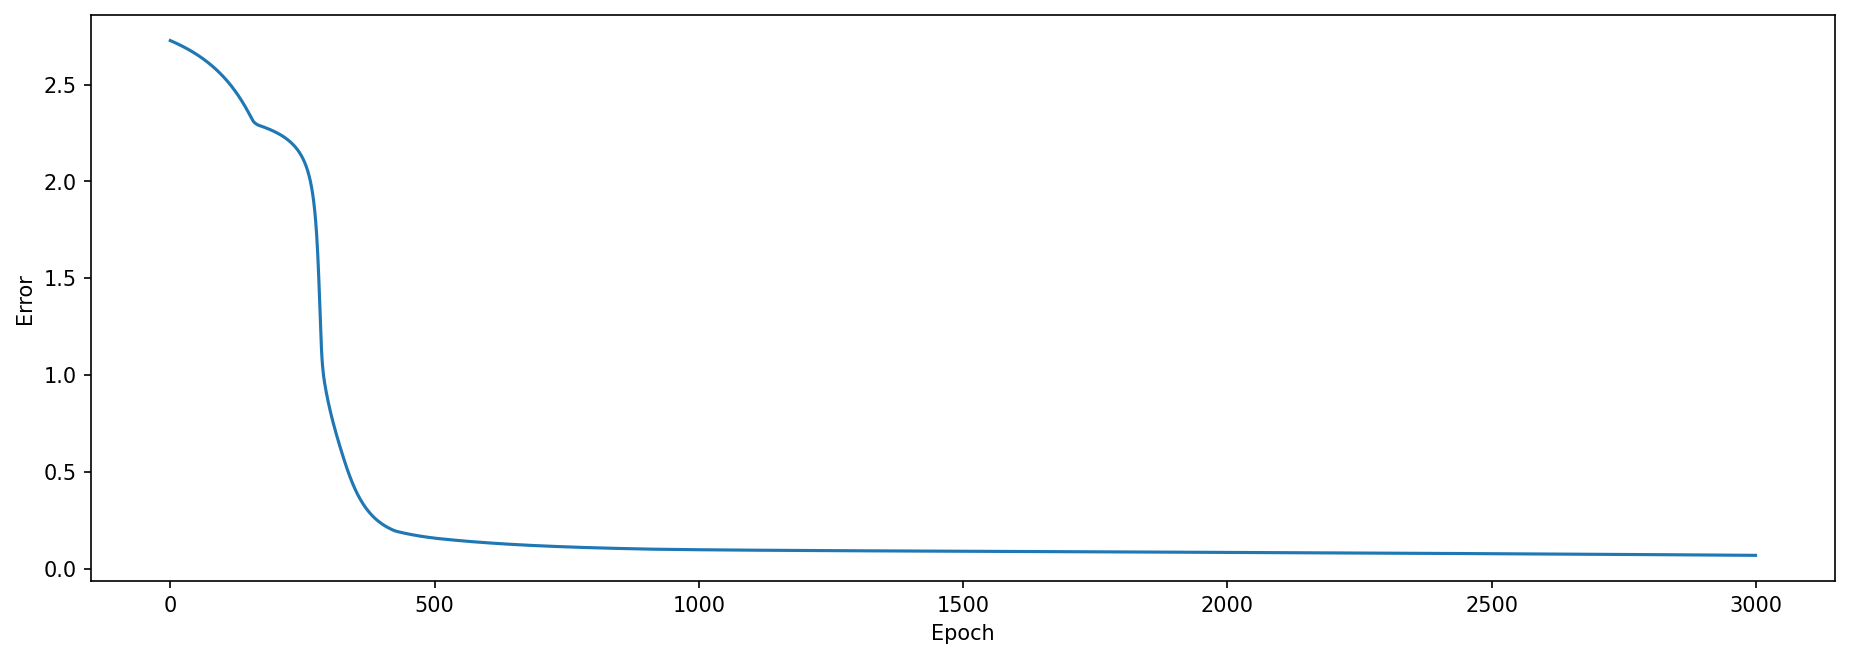

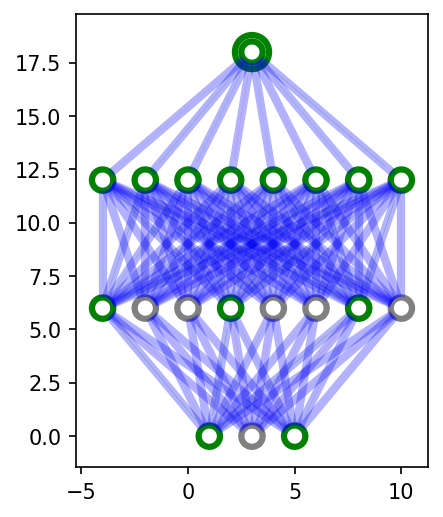

In [100]:
NN2 = setup_net()
NN2.set_input(inputs, outputs)
NN2.train(3000)
NN2.plot_train_history()
NN2.set_input(inputs[5], outputs[5])
NN2.forward()
NN2.draw(outputs[5])

Here you see propagating the input up to the output. The big circle around the output is the 'correct' answer, we trained for.
If one tries different input -> output relations it can be seen, that not all are trained correct every time. Here it starts to become interesting, as the training success depends on the random initialization of the weights within the layers. It might also be possible, that the network is not capable to learn the input output relation. For example we choose a network, which is not very powerfull, as it does not contain bias and uses sigmoid activation layers. If all inputs are 0 the output must be 0 therefore. We check all other input output combinations and see, that the network is capable of learning them:

In [101]:
lr = 2
hidden_size = 8
missed = 0
stats = {}
for k in range(8):
    stats[k] = 0
for i in range(128):
    for k in range(8):
        NN2 = setup_net()
        bbs = ('{0:0'+str(i_bits)+'b}').format(i)
        outputs = bbs_to_output(bbs)
        NN2.set_input(inputs, outputs)
        NN2.train(5000 * 2 ** k)
        errsum = np.sum(NN2.error**2)
        if errsum <= 0.25:
            break
    stats[k] += 1
    if errsum > 0.25:
        missed += 1
    print('%4d %8s %6.3f %3d %d' % (i, bbs, errsum, missed, k))
print('tried %4d  missed: %3d' % (i + 1, missed), stats)

   0 00000000  0.002   0 0
   1 00000001  0.016   0 0
   2 00000010  0.035   0 0
   3 00000011  0.012   0 0
   4 00000100  0.037   0 0
   5 00000101  0.010   0 0
   6 00000110  0.013   0 0
   7 00000111  0.021   0 0
   8 00001000  0.034   0 0
   9 00001001  0.013   0 1
  10 00001010  0.043   0 0
  11 00001011  0.024   0 0
  12 00001100  0.039   0 0
  13 00001101  0.017   0 0
  14 00001110  0.036   0 0
  15 00001111  0.030   0 0
  16 00010000  0.044   0 0
  17 00010001  0.009   0 0
  18 00010010  0.037   0 0
  19 00010011  0.008   0 0
  20 00010100  0.043   0 0
  21 00010101  0.018   0 0
  22 00010110  0.016   0 0
  23 00010111  0.009   0 0
  24 00011000  0.006   0 2
  25 00011001  0.018   0 1
  26 00011010  0.083   0 0
  27 00011011  0.059   0 0
  28 00011100  0.113   0 0
  29 00011101  0.011   0 0
  30 00011110  0.155   0 1
  31 00011111  0.029   0 0
  32 00100000  0.036   0 0
  33 00100001  0.027   0 0
  34 00100010  0.038   0 0
  35 00100011  0.020   0 0
  36 00100100  0.006   0 2
 

 From the list one can identify difficult combinations to train. If one runs them, sometimes it fails...

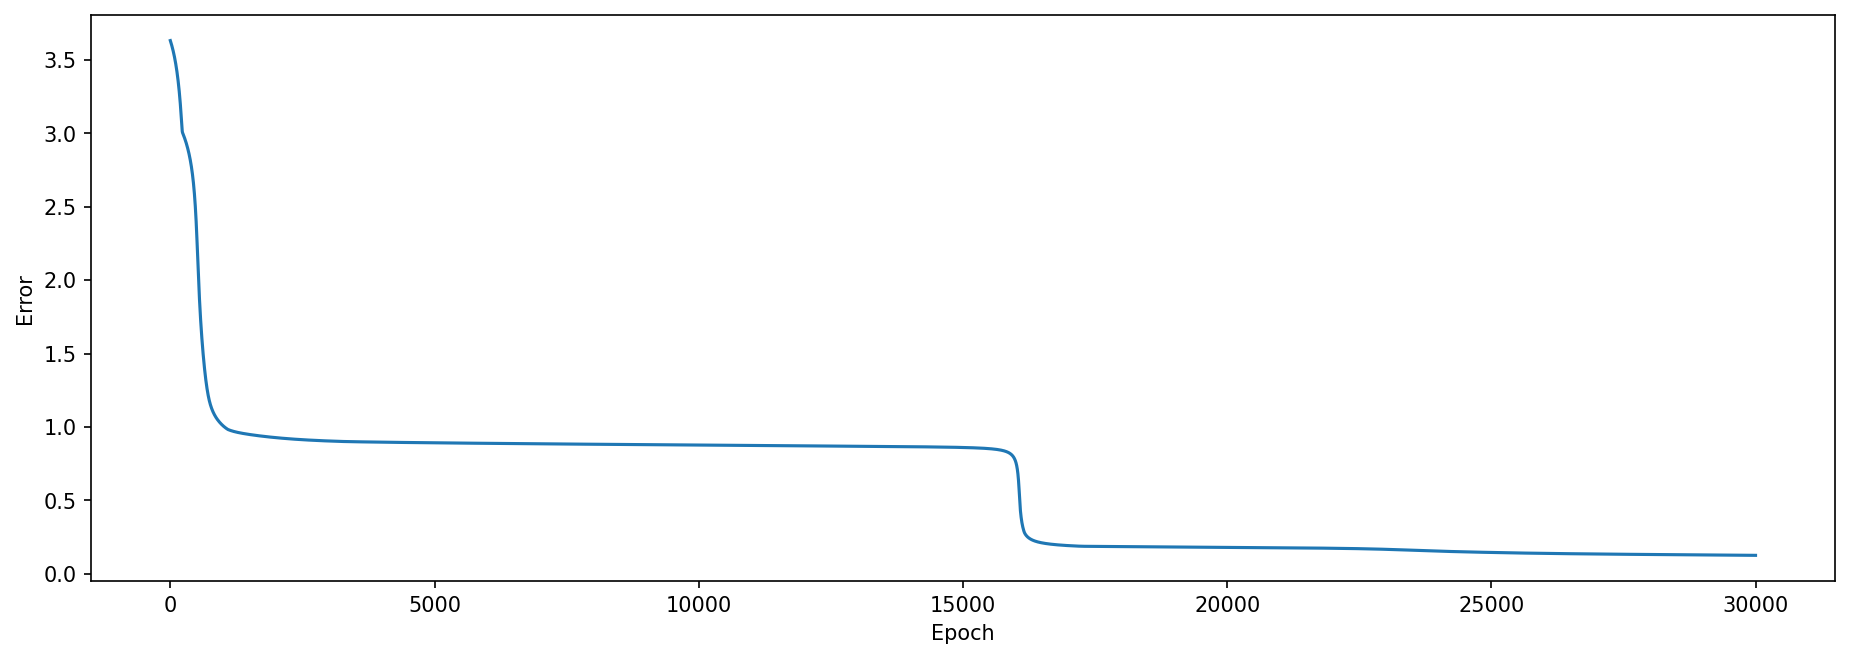

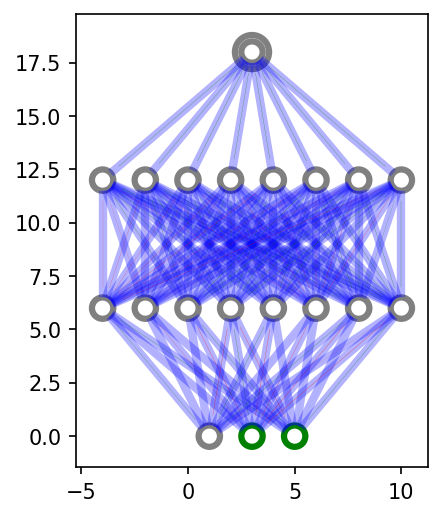

In [103]:
lr = 1
NN2 = setup_net()
outputs = bbs_to_output('01101100')
NN2.set_input(inputs, outputs)
NN2.train(30000)
NN2.plot_train_history()
i=3
NN2.set_input(inputs[i],outputs[i])
NN2.forward()
NN2.draw(outputs[i])

Now we will try so called few shot learning. As you can see from the training graph abough, usually the network uses every input output combination a very big number of times till the training is good. This is different from humans, which usualy learn a task with very few examples. We try this now

  0 Label 00100001 Error  1.501     Ready   1
  1 Label 01010010 Error  1.679     Ready   2
  2 Label 00000100 Error  0.396     Ready   1
  3 Label 00111100 Error  0.504     Ready   2
  4 Label 00010001 Error  0.268     Ready   2
  5 Label 01000011 Error  1.339     Ready   7
  6 Label 01100001 Error  1.701     Ready   1
  7 Label 00000000 Error  0.010     Ready   0
  8 Label 00101000 Error  1.147     Ready   1
  9 Label 00011110 Error  1.153     Ready   2
 10 Label 01110001 Error  0.209     Ready   1
 11 Label 00011111 Error  0.297     Ready   2
 12 Label 01011110 Error  0.307     Ready   3
 13 Label 01111001 Error  0.298     Ready   1
 14 Label 01000110 Error  0.292     Ready   5
 15 Label 00111111 Error  0.131     Ready   3
 16 Label 01001100 Error  0.125     Ready   3
 17 Label 01011111 Error  0.103     Ready   1
 18 Label 00001011 Error  0.024     Ready   3
 19 Label 00011100 Error  0.174     Ready   5
 20 Label 01110101 Error  0.091     Ready   2
 21 Label 00110101 Error  0.181   

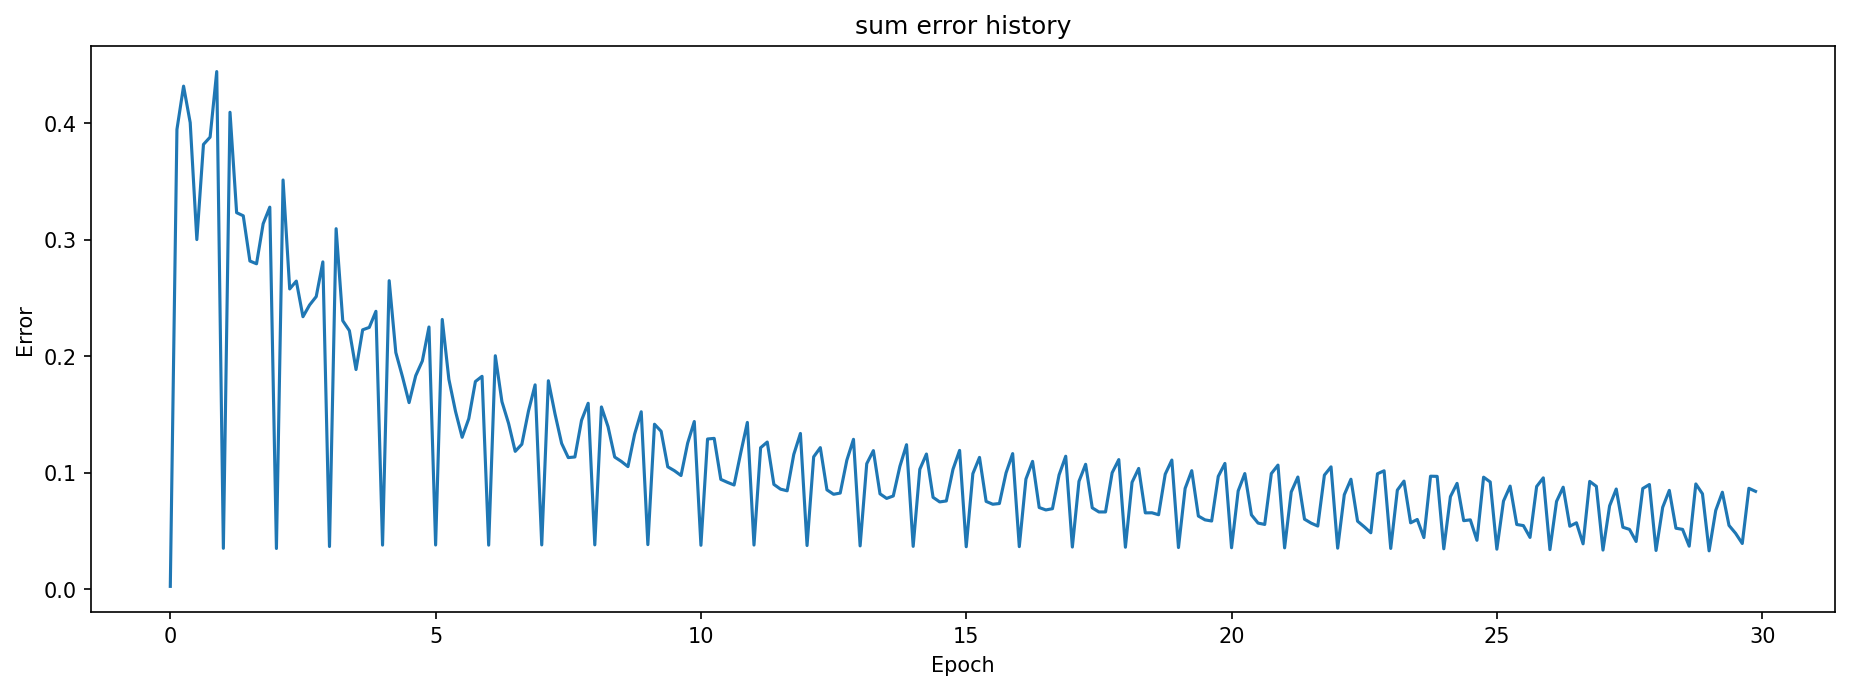

In [106]:
multi_test = 30 
%run -i _code_.py

as you can see, with seeing every data point only a small number of times, this trains the model. We use a very simple straight forward approach. With one data point we do a training up to a treshold, than we take the next data point. From the table you can see, that most of the time the training is successfull, but sometimes it is not.

In fact the training here is a little more improved: For every test we reinitialize the random weights of the last layer and train with a different randomly chosen output combination. We train the first layer with a slower learning rate, but this is not yet important. This simple examples work even without this additional improvments.

Now we will start using emnist data, which will result in few shot learning of handwritten digit recognition.